In [234]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas_profiling

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss

from sklearn.model_selection import train_test_split, KFold, cross_validate, cross_val_predict
from sklearn.metrics import plot_confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import GridSearchCV

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import sys
sys.path.append('../')
%matplotlib inline
pd.options.display.max_columns = 25

<img src="img/alura-vox.png" style="height:260px">

# Tarefas da Semana 3

- Verificar se a variável target está balanceada (undersampling ou oversampling)
- Aplicar encoding nos seus dados
- Criar dois ou mais modelos de Machine Learning
- Avaliar cada modelo utilizando métricas de ML
- Escolher o melhor modelo (justificar a escolha)
- Otimizar o melhor modelo
- Verificar qual o melhor tipo de balanceamento com esses dados

# Carregando Base de Dados
### Os dados usados já foram tratados e organizados na semana anterior

In [314]:
dados = pd.read_json('../Dados/dados_churn_clean.json')
dados.head()

,cliente_id,churn,genero,idoso,casado,dependentes,duracao_contrato,assinatura_telefone,linhas_extras,assinatura_internet,protecao_online,backup_nuvem,protecao_dispositivo,suporte_tecnico,streaming_tv,streaming_filmes,contrato,cobranca_digital,metodo_pagamento,custo_diario,custo_mensal,custo_total
0,0002-ORFBO,Não,Feminino,Não,Sim,Sim,9,Sim,Não,dsl,Não,Sim,Não,Sim,Sim,Não,Anual,Sim,Cheque,2.19,65.6,593.30
1,0003-MKNFE,Não,Masculino,Não,Não,Não,9,Sim,Sim,dsl,Não,Não,Não,Não,Não,Sim,Mensal,Não,Cheque,2.00,59.9,542.40
2,0004-TLHLJ,Sim,Masculino,Não,Não,Não,4,Sim,Não,fibra,Não,Não,Sim,Não,Não,Não,Mensal,Sim,Cheque eletrônico,2.46,73.9,280.85
3,0011-IGKFF,Sim,Masculino,Sim,Sim,Não,13,Sim,Não,fibra,Não,Sim,Sim,Não,Sim,Sim,Mensal,Sim,Cheque eletrônico,3.27,98.0,1237.85
4,0013-EXCHZ,Sim,Feminino,Sim,Sim,Não,3,Sim,Não,fibra,Não,Não,Não,Sim,Sim,Não,Mensal,Sim,Cheque,2.80,83.9,267.40


# Ocorrências de Churn
Esses valores serão analisados posteriormente para verificar a possibilidade de tratamento dos dados com a aplicação de técnicas de under ou oversampling.

In [315]:
churn = dados.churn.value_counts().to_frame().T
churn['Proporção'] = round(churn['Não'] / churn['Sim'],2)
churn

,Não,Sim,Proporção
churn,5174,1869,2.77


Podemos ver que temos uma proporção de 2.77 : 1 na variável target `churn`.

# Verificando as variáveis categóricas que serão tratadas

In [316]:
for coluna in dados.columns[1:]:
    if dados[coluna].dtype == 'object':
        print(f'Variável {coluna}:', dados[coluna].unique())

Variável churn: ['Não' 'Sim']
Variável genero: ['Feminino' 'Masculino']
Variável idoso: ['Não' 'Sim']
Variável casado: ['Sim' 'Não']
Variável dependentes: ['Sim' 'Não']
Variável assinatura_telefone: ['Sim' 'Não']
Variável linhas_extras: ['Não' 'Sim' 'Sem assinatura de telefone']
Variável assinatura_internet: ['dsl' 'fibra' 'não contratada']
Variável protecao_online: ['Não' 'Sim' 'internet não contratada']
Variável backup_nuvem: ['Sim' 'Não' 'internet não contratada']
Variável protecao_dispositivo: ['Não' 'Sim' 'internet não contratada']
Variável suporte_tecnico: ['Sim' 'Não' 'internet não contratada']
Variável streaming_tv: ['Sim' 'Não' 'internet não contratada']
Variável streaming_filmes: ['Não' 'Sim' 'internet não contratada']
Variável contrato: ['Anual' 'Mensal' 'Bianual']
Variável cobranca_digital: ['Sim' 'Não']
Variável metodo_pagamento: ['Cheque' 'Cheque eletrônico' 'Cartão de crédito' 'Transferência bancária']


# Explicando o processo de ajuste:
Vamos realizar algumas alterações dentro da base de dados para que seja possível rodar os testes e criar o modelo de machine learning.

## As variáveis que serão tratadas neste momento:
Para isso vamos alterar os valores `Sim` e `Não` para `1` e `0` respectivamente, para as variáveis categóricas destacadas:
* `churn`
* `genero`: esta feature seguirá como 'Masculino': 0, 'Feminino': 1
* `idoso`
* `casado`
* `dependentes`
* `assinatura_telefone`
* `linhas_extras`: nesta feature definiremos 'Sem assinatura de telefone': 0
* `protecao_online`: nesta feature definiremos 'internet não contratada': 0 e seguirá assim para as demais que dependem da assinatura de internet
* `backup_nuvem`
* `protecao_dispositivo`
* `suporte_tecnico`
* `streaming_tv`
* `streaming_filmes`
* `cobranca_digital`

Já as variáveis `assinatura_internet`, `contrato` e `metodo_pagamento`  serão tratadas utilizando o **método Dummies** da biblioteca Pandas.

# Remoção das colunas que não farão diferença no nosso modelo
As features abaixo serão removidas.
- `cliente_id` apenas contém a ID de cada cliente, não afetando de qualquer maneira a possibilidade de churn dos clientes
- `custo_diario` foi calculada pela divisão do custo mensal por trinta dias do mês e não trará grandes informações para os nossos modelos de machine learning
- `custo_total` é produto da multiplicação da duração de contrato de cada cliente por seu custo total, e as informações sobre custo mensal constarão nos modelos desenvolvidos

In [317]:
dados.drop(columns = ['cliente_id', 'custo_diario', 'custo_total'], inplace = True)

# Realizando transformação nas variáveis citadas
Faremos a transformação das classes das variáveis através de um simples replace rodando num for loop

In [318]:
ajuste_binario = {'Não': 0, 'Sim': 1, 'Masculino': 0, 'Feminino': 1, 'Sem assinatura de telefone': 0, 'internet não contratada': 0}
selecao = ['churn', 'genero', 'idoso', 'casado', 'dependentes', 'assinatura_telefone', 'linhas_extras', 'protecao_online', 'backup_nuvem', 'protecao_dispositivo', 'suporte_tecnico', 'streaming_tv', 'streaming_filmes', 'cobranca_digital']

for coluna in dados.columns:
    if coluna in selecao:
        dados[coluna].replace(ajuste_binario, inplace = True)

## Gerando Dummies para as variáveis categóricas
Seleção das variáveis para então geração de dummies

In [319]:
variaveis_dummy = []
for coluna in dados.columns[1:]:
    if dados[coluna].dtype == 'object':
        print(f'Variável {coluna}:', dados[coluna].unique())
        variaveis_dummy.append(coluna)

Variável assinatura_internet: ['dsl' 'fibra' 'não contratada']
Variável contrato: ['Anual' 'Mensal' 'Bianual']
Variável metodo_pagamento: ['Cheque' 'Cheque eletrônico' 'Cartão de crédito' 'Transferência bancária']


In [320]:
dados = pd.get_dummies(data = dados, columns = variaveis_dummy)

In [321]:
dados.head()

,churn,genero,idoso,casado,dependentes,duracao_contrato,assinatura_telefone,linhas_extras,protecao_online,backup_nuvem,protecao_dispositivo,suporte_tecnico,...,cobranca_digital,custo_mensal,assinatura_internet_dsl,assinatura_internet_fibra,assinatura_internet_não contratada,contrato_Anual,contrato_Bianual,contrato_Mensal,metodo_pagamento_Cartão de crédito,metodo_pagamento_Cheque,metodo_pagamento_Cheque eletrônico,metodo_pagamento_Transferência bancária
0,0,1,0,1,1,9,1,0,0,1,0,1,...,1,65.6,1,0,0,1,0,0,0,1,0,0
1,0,0,0,0,0,9,1,1,0,0,0,0,...,0,59.9,1,0,0,0,0,1,0,1,0,0
2,1,0,0,0,0,4,1,0,0,0,1,0,...,1,73.9,0,1,0,0,0,1,0,0,1,0
3,1,0,1,1,0,13,1,0,0,1,1,0,...,1,98.0,0,1,0,0,0,1,0,0,1,0
4,1,1,1,1,0,3,1,0,0,0,0,1,...,1,83.9,0,1,0,0,0,1,0,1,0,0


In [322]:
dados.shape

(7043, 26)

# Salvando dados preparados para Machine Learning

In [323]:
dados.to_json('dados_ml_ready.json')

# Produzindo Matriz de Correlação

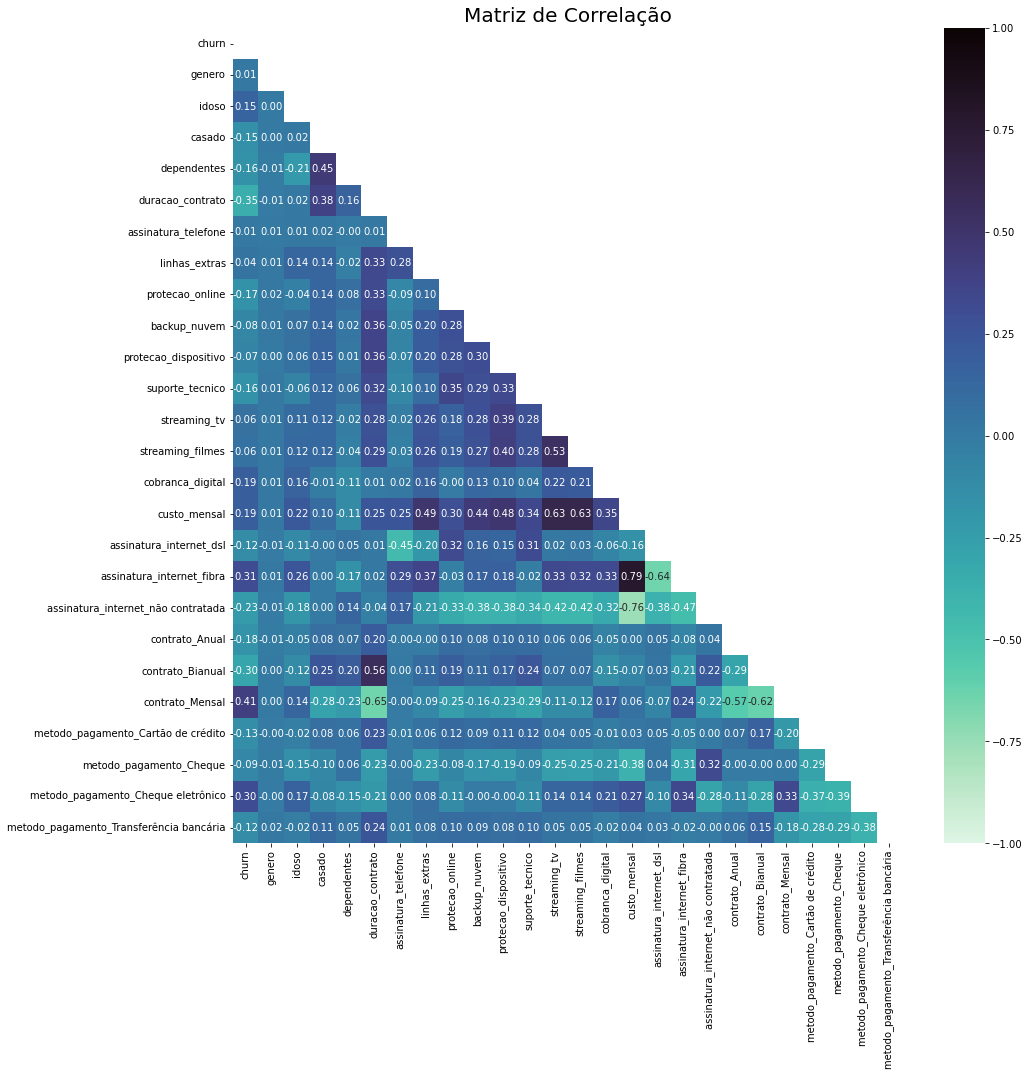

In [324]:
correlacao = dados.corr()
mascara = np.triu(np.ones_like(correlacao, dtype = bool)) # máscara para ocultar dados repetidos na matriz de correlação
fig, ax = plt.subplots(figsize = (15,15))
heatmap_corr = sns.heatmap(correlacao, mask = mascara, cmap = 'mako_r', annot=True, fmt='.2f', ax = ax, vmin=-1, vmax=1)
ax.set_title('Matriz de Correlação', fontsize = 20)
fig = heatmap_corr.get_figure()
fig.savefig('img/matriz_correlacao.png')
plt.show()

# Observando a correlação destacando o Churn
Abaixo estão destacadas as correlações classificadas como moderadas

In [325]:
correlacao_churn = round(correlacao['churn'].to_frame(), 2)
correlacao_churn = correlacao_churn.sort_values(by = ['churn'], ascending = False)[1:]
filtro_correlacoes_churn = correlacao_churn.query('churn >= 0.3 or churn <= -0.3')
filtro_correlacoes_churn

,churn
contrato_Mensal,0.41
assinatura_internet_fibra,0.31
metodo_pagamento_Cheque eletrônico,0.30
contrato_Bianual,-0.30
duracao_contrato,-0.35


Podemos ver que as variáveis `contrato_Mensal`, `assinatura_internet_fibra` e `metodo_pagamento_Cheque eletrônico` possuem correlação positiva, classificadas como moderadas.

Já `contrato_Bianual` e `duracao_contrato` são as únicas que apresentam correlação negativa, também classificadas como moderadas. 

**Nota**: correlação, seja positiva ou negativa, não indica casualidade.

# Gerando Perfil da Base de Dados
### O perfil dos dados será salvo num documento externo no formato HTML, permitindo sua posterior consulta

In [246]:
perfil_dados = pandas_profiling.ProfileReport(dados)
perfil_dados.to_file('pandas-profile/perfil_aluravoz.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

## A variável target está balanceada?
Não, conferimos sua proporção no começo do notebook e é possível verificar a diferença de classes da variável target `churn`.

Baseado nesse fato, iremos balancear sua proporção para garantir melhores resultados nos modelos gerados.

# Balanceando os dados: Oversampling.

Primeiramente vamos trabalhar balanceando nossa variável target `churn` com a ténica de oversamping conhecida como SMOTE, nome e sigla para **Synthetic Minority Oversampling Technique**.

Segundo [Machado (2007)](https://repositorio.unb.br/handle/10482/1397), SMOTE consiste em gerar casos sintéticos (artificiais) para a classe de interesse a partir dos casos já existentes. Os novos casos são gerados na vizinhança de cada caso da classe minoritária com o intuito de se crescer o espaço de decisão desta classe e aumentar o poder de generalização dos classificadores obtidos.

## Organizando a base de dados para a aplicação do oversampling

In [326]:
x = dados.drop(columns = 'churn')
y = dados.churn

In [327]:
SEED = 86

smote = SMOTE(random_state = SEED)
x_resampled, y_resampled = smote.fit_resample(x,y)
dados_oversampling = pd.concat([y_resampled, x_resampled], axis = 1)

### Conferindo ajustes na base de dados e variável target

In [328]:
dados_oversampling.shape

(10348, 26)

In [329]:
dados_oversampling.churn.value_counts()

0    5174
1    5174
Name: churn, dtype: int64

# Separando a base de dados em treino e teste para geração dos modelos de machine learning

In [330]:
x = dados_oversampling.drop(columns = 'churn')
y = dados_oversampling.churn

SEED = 86

x_treino, x_teste, y_treino, y_teste = train_test_split(x, y, test_size = 0.25, random_state = SEED)

# Criação de Modelos de Machine Learning
Trabalharemos com os seguintes modelos:

- Decision Tree
- Random Forest
- Ada Boost

Neles iremos aplicar a validação cruzada, com 10 folds, com seus dados sendo embaralhados. Os modelos contarão com as seguintes métricas: Acurácia, Precisão, Recall, F1 Score, e ROC AUC.

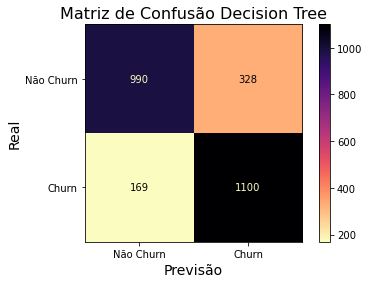

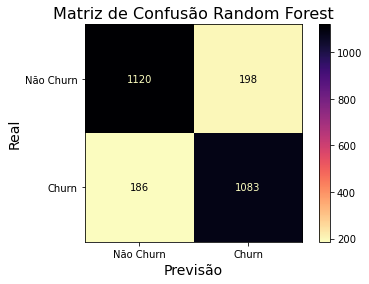

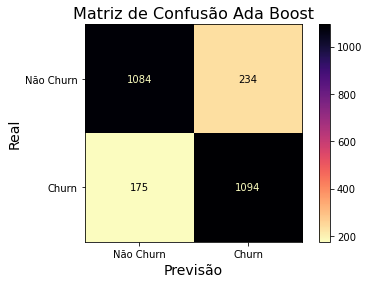

In [331]:
SEED = 86
cv = KFold(n_splits = 10, shuffle = True, random_state = SEED)

modelos = [
    ['Decision Tree', DecisionTreeClassifier(max_depth = 5, random_state = SEED)],
    ['Random Forest', RandomForestClassifier(random_state = SEED)],
    ['Ada Boost', AdaBoostClassifier(n_estimators=100, random_state = SEED)]
]


comparativo = []
balanceamento = 'SMOTE'
for nome_modelo, modelo in modelos:
    resultados_cv = cross_validate(modelo, x_treino, y_treino, cv = cv, scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc'])
    
    clf = modelo
    clf.fit(x_treino, y_treino)
    y_treino_prev = cross_val_predict(modelo, x_treino, y_treino, cv = cv)
    
    acuracia = round(resultados_cv['test_accuracy'].mean()*100, 2)
    precisao = round(resultados_cv['test_precision'].mean()*100, 2)
    recall = round(resultados_cv['test_recall'].mean()*100, 2)
    f1score = round(resultados_cv['test_f1'].mean()*100, 2)
    roc_auc = round(resultados_cv['test_roc_auc'].mean(), 4)
    
    comparativo.append([nome_modelo, balanceamento, acuracia, precisao, recall, f1score, roc_auc])
    
    plot_confusion_matrix(modelo, x_teste, y_teste, cmap=plt.cm.magma_r, display_labels=['Não Churn', 'Churn'])
    plt.title(f'Matriz de Confusão {nome_modelo}', fontsize = 16)
    plt.ylabel('Real', fontsize = 14)
    plt.xlabel('Previsão', fontsize = 14)   
    plt.show()
df_comparativo = pd.DataFrame(comparativo, columns = ['Nome Modelo', 'Balanceamento' ,'Acurácia', 'Precisão', 'Recall', 'F1 Score', 'ROC AUC'])
df_filtro = df_comparativo.copy() # copia para facilitar destaque no final

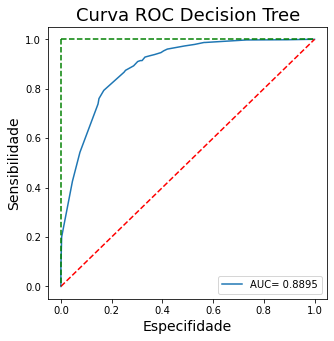

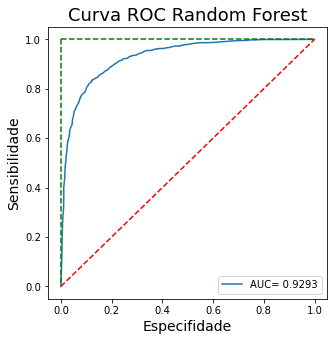

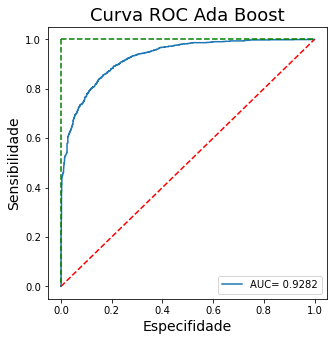

In [332]:
for nome_modelo, modelo in modelos:
    prob_previsao = modelo.predict_proba(x_teste)[:,1]

    tfp, tvp, limite = roc_curve(y_teste, prob_previsao)
    auc = roc_auc_score(y_teste, prob_previsao)

    plt.subplots(1, figsize=(5,5))
    plt.title(f'Curva ROC {nome_modelo}', fontsize = 18)
    plt.xlabel('Especifidade', fontsize = 14)
    plt.ylabel('Sensibilidade', fontsize = 14)
    plt.plot(tfp,tvp, label = 'AUC= '+str(round(auc, 4))) 
    plt.plot([0, 1], ls="--", c = 'red')
    plt.plot([0, 0], [1, 0], ls="--", c = 'green'), plt.plot([1, 1], ls="--", c = 'green')
    plt.legend(loc = 4)
    plt.show()

## Tabela comparativa dos modelos
Lembrando que esses modelos foram gerados com dados que foram **balanceados com SMOTE**.

In [333]:
df_comparativo

,Nome Modelo,Balanceamento,Acurácia,Precisão,Recall,F1 Score,ROC AUC
0,Decision Tree,SMOTE,80.13,78.27,83.96,80.94,0.8769
1,Random Forest,SMOTE,84.24,83.73,85.24,84.47,0.9246
2,Ada Boost,SMOTE,83.11,81.47,86.01,83.65,0.9169


# Agora iremos trabalhar com Undersamping aplicando Near Miss
Segundo [Bhoomika Madhukar (2020)](https://analyticsindiamag.com/using-near-miss-algorithm-for-imbalanced-datasets/), o algoritmo Near Miss realiza undersampling da base de dados observando a distribuição de classes e eliminando aleatoriamente amostras da classe maior. Quando dois pontos pertencentes a classes diferentes estão muito próximos um do outro na distribuição, esse algoritmo elimina o ponto de dados da classe maior, tentando equilibrar a distribuição.

Existem 3 variações desse algoritmo, mas iremos trabalhar com a [versão 1, estalecida como default](https://imbalanced-learn.org/dev/references/generated/imblearn.under_sampling.NearMiss.html).

## Conferindo a existência da classe desbalanceada

In [334]:
dados.shape

(7043, 26)

## Organizando a base de dados para a aplicação do undersampling

In [335]:
x = dados.drop(columns = 'churn')
y = dados.churn

In [336]:
SEED = 86

nearmiss = NearMiss()
x_resampled, y_resampled = nearmiss.fit_resample(x, y)
dados_undersampling = pd.concat([y_resampled, x_resampled], axis = 1)

### Conferindo novo tamanho da base de dados após aplicação do undersampling

In [337]:
dados_undersampling.churn.value_counts()

0    1869
1    1869
Name: churn, dtype: int64

## Separando grupos de teste e treino para a base de dados balanceada

In [338]:
x = dados_undersampling.drop(columns = 'churn')
y = dados_undersampling.churn
x_treino, x_teste, y_treino, y_teste = train_test_split(x, y, test_size = 0.25, random_state = SEED)

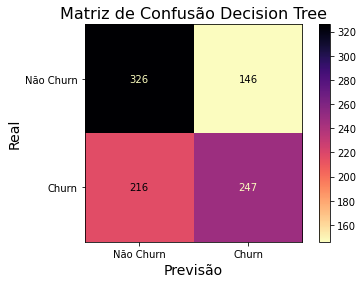

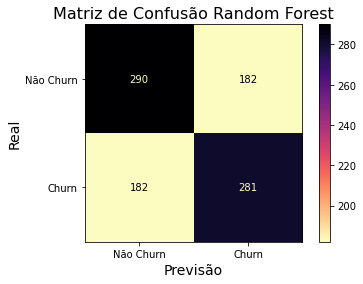

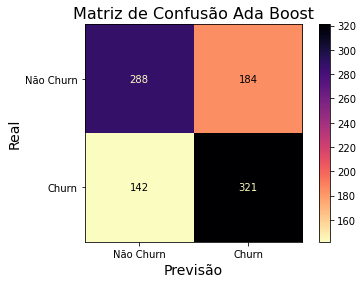

In [339]:
SEED = 86
cv = KFold(n_splits = 10, shuffle = True, random_state = SEED)

modelos = [
    ['Decision Tree', DecisionTreeClassifier(max_depth = 5, random_state = SEED)],
    ['Random Forest', RandomForestClassifier(random_state = SEED)],
    ['Ada Boost', AdaBoostClassifier(n_estimators=100, random_state = SEED)]
]

balanceamento = 'Near Miss'
for nome_modelo, modelo in modelos:
    resultados_cv = cross_validate(modelo, x_treino, y_treino, cv = cv, scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc'])
    
    clf = modelo
    clf.fit(x_treino, y_treino)
    y_treino_prev = cross_val_predict(modelo, x_treino, y_treino, cv = cv)
    
    acuracia = round(resultados_cv['test_accuracy'].mean()*100, 2)
    precisao = round(resultados_cv['test_precision'].mean()*100, 2)
    recall = round(resultados_cv['test_recall'].mean()*100, 2)
    f1score = round(resultados_cv['test_f1'].mean()*100, 2)
    roc_auc = round(resultados_cv['test_roc_auc'].mean(), 4)
    
    comparativo.append([nome_modelo, balanceamento, acuracia, precisao, recall, f1score, roc_auc])
    
    plot_confusion_matrix(modelo, x_teste, y_teste, cmap=plt.cm.magma_r, display_labels=['Não Churn', 'Churn'])
    plt.title(f'Matriz de Confusão {nome_modelo}', fontsize = 16)
    plt.ylabel('Real', fontsize = 14)
    plt.xlabel('Previsão', fontsize = 14)   
    plt.show()
df_comparativo = pd.DataFrame(comparativo, columns = ['Nome Modelo', 'Balanceamento' ,'Acurácia', 'Precisão', 'Recall', 'F1 Score', 'ROC AUC'])

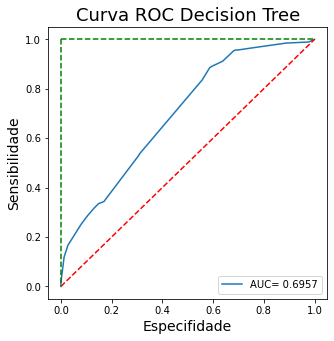

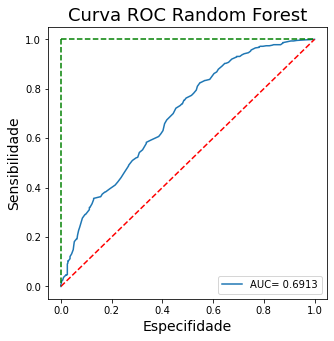

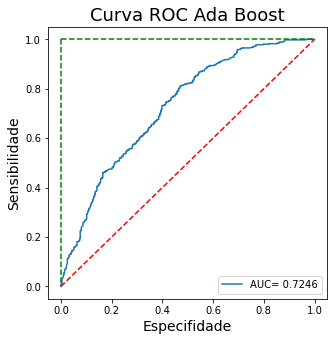

In [340]:
for nome_modelo, modelo in modelos:
    prob_previsao = modelo.predict_proba(x_teste)[:,1]

    tfp, tvp, limite = roc_curve(y_teste, prob_previsao)
    auc = roc_auc_score(y_teste, prob_previsao)

    plt.subplots(1, figsize=(5,5))
    plt.title(f'Curva ROC {nome_modelo}', fontsize = 18)
    plt.xlabel('Especifidade', fontsize = 14)
    plt.ylabel('Sensibilidade', fontsize = 14)
    plt.plot(tfp,tvp, label = 'AUC= '+str(round(auc, 4))) 
    plt.plot([0, 1], ls="--", c = 'red')
    plt.plot([0, 0], [1, 0], ls="--", c = 'green'), plt.plot([1, 1], ls="--", c = 'green')
    plt.legend(loc = 4)
    plt.show()

In [341]:
df_comparativo

,Nome Modelo,Balanceamento,Acurácia,Precisão,Recall,F1 Score,ROC AUC
0,Decision Tree,SMOTE,80.13,78.27,83.96,80.94,0.8769
1,Random Forest,SMOTE,84.24,83.73,85.24,84.47,0.9246
2,Ada Boost,SMOTE,83.11,81.47,86.01,83.65,0.9169
3,Decision Tree,Near Miss,63.61,61.81,73.19,66.42,0.6852
4,Random Forest,Near Miss,64.75,64.31,67.12,65.60,0.7046
5,Ada Boost,Near Miss,64.72,62.74,73.35,67.56,0.7110


# A escolha do melhor modelo
O modelo apresentou melhores resultados foi **Random Forest** balanceado com **SMOTE**.
Destacou-se pelo resultado nas seguintes métricas:
- Recall: 85,24%
- F1 Score: 84,47%
- AUC: 0,9246

Apesar de todas as métricas terem como objetivo comum apontar o quão distante o modelo está da classificação perfeita, modelos de classificação binária dependem muito mais da interpretação
Apesar do modelo Ada Boost ter apresentado maior Recall quando comparado com o resultado do Random Forest, tivemos melhor resultado de ROC AUC para Random Forest, determinando a sua escolha.

Razões para destacar a importância do Recall/Revocação: por ser definido como a proporção de previsões corretas da categoria alvo, Verdadeiros Positivos em relação a soma dos Verdadeiros Positivos com os Falsos Negativos. Nesse sentido acaba dando maior ênfase para os erros por Falso Negativo. Em outras palavras: **de cada 100 clientes, 85 deixarão a Alura Voz**, sendo classificados como churn.

Razões para destacarr AUC: a área sob a curva resume o desempenho do classificar numa só medida. A AUC é calculada como uma área que varia de 0 a 1, mas a interpretação do valor da AUC é uma probabilidade. Ou seja, uma AUC = 0,90 tem a interpretação de que, se duas observações forem feitas sobre qualquer um dos valores previstos, a probabilidade de serem corretamente ordenados é a própria AUC, 90%. E no caso dos modelos usados, **Random Forest apresentou 92,46%**, deixando Ada Boost na segunda posição.

# Vamos trabalhar para aprimorar o modelo Random Forest

Iremos trabalhar com a base de dados que foi balanceada com **SMOTE**.

In [297]:
dados = dados_oversampling.copy()

In [298]:
x = dados.drop(columns = 'churn')
y = dados.churn

In [299]:
SEED = 86
x_treino, x_teste, y_treino, y_teste = train_test_split(x, y, test_size = 0.25, random_state = SEED)

## Primeiro vamos buscar as melhores features para trabalhar o nosso modelo
Após buscar e identificar, vamos listar as **20 melhores features**.

Em seguida essas features serão aplicadas nos grupos de treino e teste para o modelo final.

In [300]:
k = 20
k_best = SelectKBest(chi2, k=k)

k_best.fit(x_treino, y_treino)
melhores_variaveis = k_best.get_feature_names_out()

for var in melhores_variaveis:
    print(var)

genero
casado
dependentes
duracao_contrato
protecao_online
backup_nuvem
protecao_dispositivo
suporte_tecnico
cobranca_digital
custo_mensal
assinatura_internet_dsl
assinatura_internet_fibra
assinatura_internet_não contratada
contrato_Anual
contrato_Bianual
contrato_Mensal
metodo_pagamento_Cartão de crédito
metodo_pagamento_Cheque
metodo_pagamento_Cheque eletrônico
metodo_pagamento_Transferência bancária


In [301]:
x_treino_melhores = x_treino[melhores_variaveis]
x_teste_melhores = x_teste[melhores_variaveis]

## Agora vamos ajustar os hiperparâmetros para a Random Forest
Para maiores detalhes sobre os hiperparâmetros usados, segue [link](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) para a documentação oficial.

In [302]:
n_estimators = np.arange(100, 150, step=10)
criterion = ["gini", "entropy"]  
max_features = ["auto", "log2"]
max_depth = list(np.arange(2, 12, step=2))
min_samples_split = np.arange(2, 12, step=2)
min_samples_leaf = [2, 4]
bootstrap = [True, False]

parameters = {
    "n_estimators": n_estimators,
    "criterion": criterion,
    "max_features": max_features,
    "max_depth": max_depth,
    "min_samples_split": min_samples_split,
    "min_samples_leaf": min_samples_leaf,
    "bootstrap": bootstrap,
}

## Utilização do GridSearch para descobrir os melhores hiperparâmetros
Essa técnica irá testar os parâmetros conforme definidos e destacará o melhor resultado.

In [303]:
SEED = 86
clf = GridSearchCV(RandomForestClassifier(random_state = SEED), parameters, cv=3, n_jobs=-1, scoring="recall")
clf.fit(x_treino_melhores, y_treino)

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=86), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 4, 6, 8, 10],
                         'max_features': ['auto', 'log2'],
                         'min_samples_leaf': [2, 4],
                         'min_samples_split': array([ 2,  4,  6,  8, 10]),
                         'n_estimators': array([100, 110, 120, 130, 140])},
             scoring='recall')

## Quais são os melhores hiperparâmetros?

In [304]:
clf.best_params_

{'bootstrap': False,
 'criterion': 'entropy',
 'max_depth': 8,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 8,
 'n_estimators': 100}

## E qual foi o melhor score?

In [305]:
clf.best_score_

0.8763153555124991

## Vamos rodar a nossa Random Forest usando os melhores hiperparâmetros

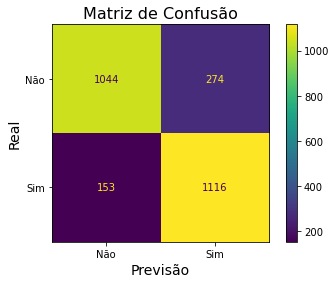

In [306]:
rforest = RandomForestClassifier(**clf.best_params_, random_state=SEED)

model = rforest.fit(x_treino, y_treino) 
y_prev = rforest.predict(x_teste)

rotulos = ['Não', 'Sim']
cm = confusion_matrix(y_teste, y_prev)
matriz_confusao = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=rotulos)
matriz_confusao.plot()

plt.title('Matriz de Confusão', fontsize = 16)
plt.ylabel('Real', fontsize = 14)
plt.xlabel('Previsão', fontsize = 14)
plt.show()

## Agora vamos gerar o modelo final

In [307]:
SEED = 86
cv = KFold(n_splits = 10, shuffle = True, random_state = SEED)
resultados_cv = cross_validate(rforest, x_treino_melhores, y_treino, cv = cv, scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc'])

clf = rforest
clf.fit(x_treino_melhores, y_treino)
y_treino_prev = cross_val_predict(modelo, x_treino_melhores, y_treino, cv = cv)

acuracia = round(resultados_cv['test_accuracy'].mean()*100, 2)
precisao = round(resultados_cv['test_precision'].mean()*100, 2)
recall = round(resultados_cv['test_recall'].mean()*100, 2)
f1score = round(resultados_cv['test_f1'].mean()*100, 2)
roc_auc = round(resultados_cv['test_roc_auc'].mean(), 4)
final = []
final.append(['Random Forest', 'SMOTE', acuracia, precisao, recall, f1score, roc_auc])

df_final = pd.DataFrame(final, columns = ['Nome Modelo', 'Balanceamento' ,'Acurácia', 'Precisão', 'Recall', 'F1 Score', 'ROC AUC'])

# Para fins de comparação: modelo inicial do Random Forest
- Sem seleção das melhores variáveis
- Sem ajuste fino dos hiperparâmetros

In [308]:
df_filtro[df_filtro['Nome Modelo'] == 'Random Forest']

,Nome Modelo,Balanceamento,Acurácia,Precisão,Recall,F1 Score,ROC AUC
1,Random Forest,SMOTE,84.24,83.73,85.24,84.47,0.9246


# Modelo final do Random Forest
* Seleção das melhores 20 features disponíveis: genero, casado, dependentes, duracao_contrato, protecao_online, backup_nuvem, protecao_dispositivo, suporte_tecnico, cobranca_digital, custo_mensal, assinatura_internet_dsl, assinatura_internet_fibra, assinatura_internet_não contratada, contrato_Anual, contrato_Bianual, contrato_Mensal, metodo_pagamento_Cartão de crédito, metodo_pagamento_Cheque, metodo_pagamento_Cheque eletrônico e metodo_pagamento_Transferência bancária.
* Seleção dos melhores hiperparâmetros para o modelo Random Forest:
    * `bootstrap`: False
    * `criterion`: 'entropy'
    * `max_depth`: 8
    * `max_features`: 'auto'
    * `min_samples_leaf`: 2
    * `min_samples_split`: 8
    * `n_estimators`: 100

In [309]:
df_final

,Nome Modelo,Balanceamento,Acurácia,Precisão,Recall,F1 Score,ROC AUC
0,Random Forest,SMOTE,82.5,79.72,87.47,83.4,0.9007


Trabalhando os hiperparâmetros e features, conseguimos melhorar nosso Recall e a AUC, possibilitando boas previsões.

Com o avançar dos meus estudos em Data Science irei reavaliar meu notebook e aprimorar esse estudo sobre machine learning aplicado à problemática do churn.